Codes for making Figure 4c in the manuscript.

# Load data

In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(gridExtra))
suppressMessages(library(rtracklayer))
suppressMessages(library(Signac))
suppressMessages(library(reshape2))
source('peak_annotation_helper.R')
source('validation_helper.R')
source('reproducibility_helper.R')

promoters_ranges <- load.promoters()

In [2]:
output_dir <- '/projects/chang/scGRN/analysis/real_data/output'
fig_dir <- '/projects/chang/scGRN/analysis/manuscript/figures'

In [3]:

# dataset
study <- 'brain_CG'
# cell types
cts <- c('Microglia', 'Excitatory', 'Inhibitory', 'Oligodendrocytes', 'Astrocytes')
# methods
methods <- c('proposed', 
             'Signac', 
             'SCENT') 

ct_name_list <- c('Excitatory', 'Inhibitory', 'Microglia', 'Oligodendrocytes')
names(ct_name_list) <- c('Exc', 'Inh', 'Mic', 'Oli')
n_ct <- length(ct_name_list)

ref_ct_list <- list(Exc = 'Neuronal',
                   Inh = 'Neuronal',
                   Mic = 'Microglia',
                   Oli = 'Oligo')

fn_suffix <- ''

## Helper function to evaluate overlap

In [4]:
eval_placseq_overlap <- function(method = 'proposed', 
                                 p_var = 'pval', 
                                 p_cutoff = 0.05, 
                                 n_cutoff = NULL,
                                 study = 'brain_CG',
                                 p_top_gene = 2000, 
                                 p_top_peak = 20000, 
                                 verbose=F, 
                                 fn_suffix='', 
                                 batch_suffix = '',
                                 all_ct = 1:4,
                                 GBM_par = NULL){
    tmp <- integer(n_ct)
    names(tmp) <- names(ct_name_list)
    n_total_pairs <- n_genes <- n_peaks <- tmp
    n_sig_plac <- n_sig <- n_total_plac <- n_total <- log_p_val <- fc <- OR <- tmp

    overlap_pairs <- sig_pairs_list <- all_pairs_list <- list()
    for(i_ct in all_ct){
        ct <- ct_name_list[i_ct]
        if(verbose) print(ct)
        # -
        # load results
        # -
        if(method == 'proposed'){
            res_df <- load_proposed(ct, datasets = study,
                                    fn_suffix = sprintf('%s%s', fn_suffix,
                                                        batch_suffix),
                                    output_dir = output_dir)[[1]]
        }else if(method == 'Signac'){
            res_df <- load_Signac(ct, datasets = study,
                                  fn_suffix = fn_suffix,
                                  output_dir = output_dir)[[1]]
        }else if(method == 'SCENT'){
            if(study == 'brain_CG'){
                if(fn_suffix != ''){
                    n_sets <- ifelse(ct %in% c('Microglia', 'Astrocytes'), 10, 20)
                }else{
                    n_sets <- ifelse(ct == 'Oligodendrocytes', 20, 10)
                }
            }else if(study == 'brain_ROSMAP'){
                n_sets <- 10
            }
            res_df <- load_SCENT(ct, n_sets = n_sets, datasets = study,
                                 fn_suffix = sprintf('%s%s%s', fn_suffix, batch_suffix, '_n_bootstrap_5000'),
                                 output_dir = output_dir)[[1]]
        }else if(method == 'GBM'){
            res_df <- load_GBM(ct, datasets = study, binarize_method = GBM_par$binarize_method, method_par = GBM_par$method_par,
                                           output_dir = output_dir)[[1]]
        }
        
        n_total_pairs[i_ct] <- nrow(res_df)
        n_genes[i_ct] <- length(unique(res_df$gene))
        n_peaks[i_ct] <- length(unique(res_df$peak))

        # load peaks as granges
        res_grange <- StringToGRanges(res_df$peak, sep = c('-', '-'))
        
        # -
        # load interactome
        # -
        if(ct == 'Microglia'){
            ref_ct <- ct
        }else if(ct %in% c('Excitatory', 'Inhibitory')){
            ref_ct <- 'Neuronal'
        }else if(ct == 'Oligodendrocytes'){
            ref_ct <- 'Oligo'
        }
        # load mapped placseq results (generated by preprocessing_placseq_to_hg38.R)
        placseq_res <- readRDS(sprintf('/projects/chang/scGRN/peak_gene/output/plac_seq/plac_seq_%s_to_reduce_FALSE.rds', 
                               ref_ct_list[[names(ct_name_list)[i_ct]]]))
        matched_ids <- intersect(placseq_res$interactome_start$id %>% unique, placseq_res$interactome_end$id %>% unique) %>% sort
        # match start and end of the interactome file
        interactome_start <- placseq_res$interactome_start[match(matched_ids, placseq_res$interactome_start$id)]
        interactome_end <- placseq_res$interactome_end[match(matched_ids, placseq_res$interactome_end$id)]

        # processed interactome results
        names(placseq_res$enhancer) <- grange_to_str(placseq_res$enhancer)
        names(res_grange) <- grange_to_str(res_grange)

        pro_interactome <- load.plac(interactome_start, interactome_end, # plac-seq interactome
                                     placseq_res$enhancer, # plac-seq identified enhancers
                                     res_grange, 
                                     promoters_ranges, # known promoters
                                     verbose=verbose)
        if(grepl('adj', p_var)){
            res_df$p_adjust <- p.adjust(res_df$pval, method = 'BH')
        }
    
        all_pairs <- paste(res_df$peak, res_df$gene, sep = '|')
        if(is.null(n_cutoff)){
            sig_inds <- res_df[[p_var]] < p_cutoff
        }else{
            sig_inds <- (1:nrow(res_df)) %in% order(res_df[[p_var]], decreasing=F)[1:n_cutoff]
        }
        #n_pair_inds <- 1:nrow(res_df)
        #sig_inds <- n_pair_inds %in% n_pair_inds[order(res_df[[p_var]], decreasing=F)[1:1017]]
        sig_pairs <- paste(res_df$peak[sig_inds], 
                           res_df$gene[sig_inds], sep = '|')

        # evaluate overlap
        n_sig_plac[i_ct] <- sum(sig_pairs %in% rownames(pro_interactome))
        n_sig[i_ct] <- length(sig_pairs)
        n_total_plac[i_ct] <- sum(all_pairs %in% rownames(pro_interactome))
        n_total[i_ct] <- length(all_pairs)
        overlap_pairs[[i_ct]] <- paste0(sig_pairs[sig_pairs %in% rownames(pro_interactome)])
        sig_pairs_list[[i_ct]] <- sig_pairs
        all_pairs_list[[i_ct]] <- all_pairs
        fc[i_ct] <- (n_sig_plac[i_ct]/n_sig[i_ct]) / ((n_total_plac[i_ct]-n_sig_plac[i_ct])/(n_total[i_ct]-n_sig[i_ct]))
        

        # https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1006982&type=printable
        # clusterSummit does not define true or false links!
        # the cluster with clusterSummit=1 is the leading bin pair within a group of adjacent bin pairs
        tab <- table(all_pairs %in% rownames(pro_interactome), all_pairs %in% sig_pairs)
        OR[i_ct] <- ifelse(nrow(tab) == 2 & ncol(tab) == 2, fisher.test(tab, alternative = 'greater')$estimate, NA)
        #print(c(tab[2,2], sum(tab[2,]), sum(tab[1,]), sum(tab[,2])))
                                         if(verbose) print(tab)
        if(ncol(tab) == 2){
            log_p_val[i_ct] <- phyper(tab[2,2], sum(tab[2,]), sum(tab[1,]), sum(tab[,2]), lower.tail=F, log.p = T)
        }else{
            log_p_val[i_ct] <- NA
        }
        
    }
    names(overlap_pairs) <- names(ct_name_list)[all_ct]
    return(list(bg_counts = list(n_total_pairs=n_total_pairs, n_genes=n_genes, n_peaks=n_peaks),
                overlap_counts = list(n_sig_plac=n_sig_plac, n_sig=n_sig,
                                      n_total_plac=n_total_plac, n_total=n_total, log_p_val=log_p_val, fc=fc, OR=OR)
               ))
}


plot_overlap_result <- function(res){
    options(repr.plot.height = 6, repr.plot.width=16)
    res_df <- do.call(cbind, res$overlap_counts) %>% melt
    colnames(res_df)[1:2] <- c('ct', 'stat')
    res_df$value[res_df$stat == 'log_p_val'] <- -res_df$value[res_df$stat == 'log_p_val']
    res_df$stat <- factor(res_df$stat, levels=names(res[[2]]),
                         labels=c('n_sig_plac', 'n_sig', 'n_total_plac', 
                                 'n_total', '-log_p', 'fold_change'))
    g <- ggplot(res_df) +
    geom_bar(aes(x=ct, y = value, fill = ct), stat='identity', show.legend = FALSE) +
    facet_wrap(~stat, scales = "free") +
    theme_classic(base_size = 20)
    print(g)
}

In [5]:
compare_methods <- function(res_list, variable, variable_label='-log(p value)', rev_sign=F,
                           subtitle = ''){
    rsign <- ifelse(rev_sign, -1, 1)
    options(repr.plot.height = 6, repr.plot.width=8)
    sum_df  <- data.frame(proposed = res_list[[1]]$overlap_counts[[variable]] * rsign,
                          Signac = res_list[[2]]$overlap_counts[[variable]] * rsign,
                          SCENT = res_list[[3]]$overlap_counts[[variable]] * rsign,
                         SEACells = res_list[[4]]$overlap_counts[[variable]] * rsign) %>% melt
    sum_df$cell_type = rep(names(res_list[[1]]$overlap_counts[[variable]]), 4)
    sum_df$variable <- factor(sum_df$variable, levels = c('SCENT', 'Signac', 'SEACells', 'proposed'),
                            labels = c('SCENT', 'Signac', 'SEACells', 'Proposed'))
    sum_df$cell_type <- factor(sum_df$cell_type,
                              levels = c('Exc', 'Inh', 'Mic', 'Oli'),
                              labels = c('Excitatory neuron', 'Inhibitory neuron',
                                        'Microglia', 'Oligodendrocyte'))
g <- ggplot(sum_df) +
geom_bar(aes(x = cell_type, fill = variable, y = value), stat = "identity", position = "dodge2",
        width = 0.7) +
labs(fill = 'method', y = variable_label, title = 'Overlap with plac-seq peak-gene links',
    subtitle = subtitle) +
theme_classic(base_size=20)
    if(variable == 'fc') g <- g  + geom_hline(yintercept = 1, linetype = 'dashed') +  coord_cartesian(ylim=c(0.98,2))
    print(g)
    return(sum_df)

}

# Compare 3 methods: scMultiMap, SCENT and Signac

In [6]:
# cutoff: adjusted p values
pvar <- 'adj_pval'

overlap_list <- list()
overlap_summary <- list()
t = 1
for(p_cutoff in c(0.05, 0.1, 0.2)){
    overlap_list[['SCENT']] <- eval_placseq_overlap(method = 'SCENT', 
                                                    p_var = pvar,
                                                    p_cutoff = p_cutoff, 
                                                    study = 'brain_CG',
                                                    verbose=F,
                                                    fn_suffix = '_batch_as_covar_adjusted',
                                                    all_ct=1:4)
    overlap_list[['proposed']] <- eval_placseq_overlap(method = 'proposed', 
                                                       p_var = pvar,
                                                       p_cutoff = p_cutoff, 
                                                       study = 'brain_CG',
                                                       verbose=F,
                                                       fn_suffix = '_batch_adjusted',
                                                       all_ct=1:4)
    overlap_list[['Signac']] <- eval_placseq_overlap(method = 'Signac', 
                                                     p_var = pvar,
                                                     p_cutoff = p_cutoff, 
                                                     study = 'brain_CG',
                                                     verbose=F,
                                                     fn_suffix = '_permu_adjusted',
                                                     all_ct=1:4)

    methods <- names(overlap_list)
    overlap_df <- data.frame(FC = sapply(methods, function(m) overlap_list[[m]]$overlap_counts$fc) %>% as.vector,
                             cell_type = rep(names(ct_name_list), 3),
                             log_p_val = sapply(methods, function(m) overlap_list[[m]]$overlap_counts$log_p_val) %>% as.vector,
                             n_sig_plac = sapply(methods, function(m) overlap_list[[m]]$overlap_counts$n_sig_plac) %>% as.vector,
                             OR = sapply(methods, function(m) overlap_list[[m]]$overlap_counts$OR) %>% as.vector,
                             method = rep(methods, each=4))
    overlap_df$method <- factor(overlap_df$method, levels = c('proposed','Signac','SCENT'), labels = c('scMultiMap','Signac','SCENT'))
    overlap_summary[[t]] <- overlap_df
    t <- t + 1
}

In [7]:
overlap_summary_df <- do.call(rbind, overlap_summary)
overlap_summary_df$cutoff <- rep( c(0.05, 0.1, 0.2), each = nrow(overlap_df))       
overlap_summary_df$cell_type <- factor(overlap_summary_df$cell_type,
                                       levels = c('Exc', 'Inh', 'Oli', 'Mic'),
                                       labels = c('Excitatory neurons', 'Inhibitory neurons' ,'Oligodendrocytes','Microglia'))

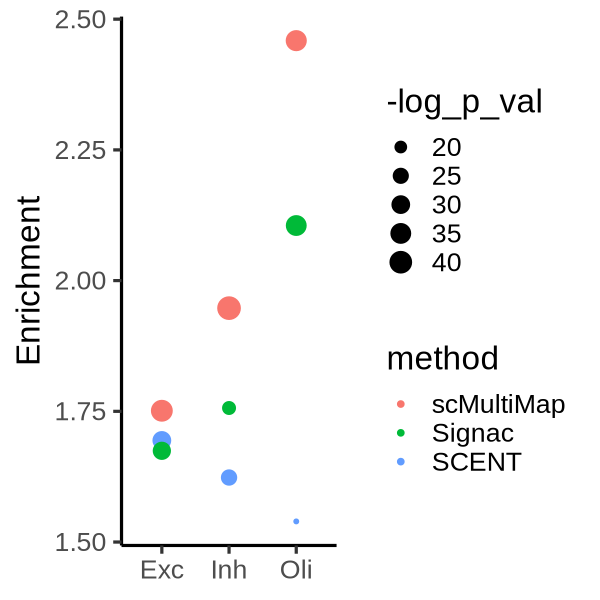

In [8]:
options(repr.plot.width = 5, repr.plot.height = 5)
overlap_summary_df_small <- overlap_summary_df[overlap_summary_df$cell_type %in% c('Excitatory neurons', 'Inhibitory neurons', 'Oligodendrocytes') &
                          overlap_summary_df$cutoff == 0.2,]
overlap_summary_df_small$cell_type <- factor(overlap_summary_df_small$cell_type,
                                             levels = unique(overlap_summary_df$cell_type),
                                             labels = c('Exc', 'Inh', 'Mic', 'Oli'))

ggplot(overlap_summary_df_small) +
geom_point(aes(x = cell_type, y = OR, color = method, size = -log_p_val)) +
theme_classic(base_size = 20) +
theme(#legend.position = "none",
     axis.title.x=element_blank()) +
labs(y = 'Enrichment')

In [9]:
#saveRDS(overlap_summary_df, sprintf('%s/results/brain_plac_seq.rds', output_dir))

# Supplementary analysis for GBM

In [10]:
pvar <- 'pval'

overlap_summary <- list()
t = 1
for(qu in c(0.85,0.9,0.95)){
    overlap_list <- eval_placseq_overlap(method = 'GBM', 
                                         p_var = pvar,
                                         p_cutoff = 0.05, 
                                         study = 'brain_CG',
                                         verbose=F,
                                         all_ct=1:4,
                                         GBM_par = list(binarize_method = 'quantile', method_par = qu))
    
    overlap_df <- data.frame(FC = overlap_list$overlap_counts$fc,
                             cell_type = names(ct_name_list),
                             log_p_val = overlap_list$overlap_counts$log_p_val,
                             n_sig_plac = overlap_list$overlap_counts$n_sig_plac,
                             OR = overlap_list$overlap_counts$OR)
    overlap_summary[[t]] <- overlap_df
    t <- t + 1
    print(overlap_list$overlap_counts$n_sig)
}

 Exc  Inh  Mic  Oli 
2539 2595 3001 3117 
 Exc  Inh  Mic  Oli 
2166 2191 2328 2395 
 Exc  Inh  Mic  Oli 
1976 1988 1970 2003 


In [11]:
overlap_gbm_df <- do.call(rbind, overlap_summary)
overlap_gbm_df$cutoff <- c(0.85,0.9,0.95)
overlap_gbm_df$cell_type <- factor(overlap_gbm_df$cell_type,
                                       levels = c('Exc', 'Inh', 'Oli', 'Mic'),
                                       labels = c('Excitatory neurons', 'Inhibitory neurons' ,'Oligodendrocytes','Microglia'))

In [12]:
overlap_gbm_df # all OR<1

,FC,cell_type,log_p_val,n_sig_plac,OR,cutoff
,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>
Exc,0.7864851,Excitatory neurons,-2.836842e-03,138,0.7742255,0.85
Inh,0.8107400,Inhibitory neurons,-9.752971e-03,133,0.8005270,0.90
Mic,0.6676739,Microglia,-1.024375e-09,203,0.6435829,0.95
Oli,0.5951415,Oligodendrocytes,-1.369932e-13,175,0.5710794,0.85
Exc1,0.7926776,Excitatory neurons,-6.405640e-03,118,0.7807435,0.90
Inh1,0.7963029,Inhibitory neurons,-9.683197e-03,110,0.7855467,0.95
Mic1,0.6456834,Microglia,-5.514286e-09,151,0.6211237,0.85
Oli1,0.5584742,Oligodendrocytes,-5.696832e-13,125,0.5341771,0.90
Exc2,0.8384768,Excitatory neurons,-3.480952e-02,113,0.8286884,0.95


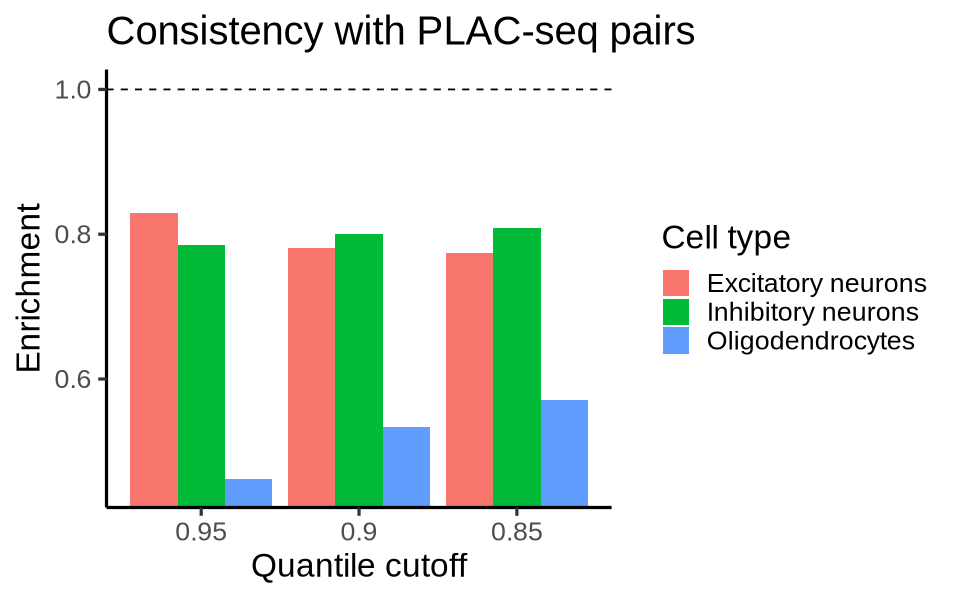

In [13]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(overlap_gbm_df[!overlap_gbm_df$cell_type == 'Microglia',],
       aes(x = factor(cutoff, levels = c(0.95,0.9,0.85), labels = c(0.95,0.9,0.85)), 
                           y = OR, fill = cell_type, group = cell_type)) +
#geom_point(size = 2) +
geom_bar(stat = 'identity', position = 'dodge') +
#geom_line() +
geom_hline(yintercept = 1, linetype = 'dashed', color = 'black') +
labs(x = 'Quantile cutoff', y = 'Enrichment', fill = 'Cell type',
    title = 'Consistency with PLAC-seq pairs') +
coord_cartesian(ylim=c(0.45,1)) +
theme_classic(base_size = 20) 

#ggsave(sprintf('%s/brain/consistency_GBM_placseq.pdf', fig_dir), width = 8, height = 5)

In [16]:
write.table(overlap_gbm_df[!overlap_gbm_df$cell_type == 'Microglia', c('cutoff', 'OR', 'cell_type')],
           '../manuscript/Source Data/supplementary/figure_10.txt')

Demonstrate that the top_n approach gives way too many pairs.

In [14]:
overlap_summary <- list()
t = 1
for(n_top in c(5,10,15)){
    overlap_list <- eval_placseq_overlap(method = 'GBM', 
                                         p_var = pvar,
                                         p_cutoff = 0.05, 
                                         study = 'brain_CG',
                                         verbose=F,
                                         all_ct=1:4,
                                         GBM_par = list(binarize_method = 'top_n', method_par = n_top))
    
    overlap_df <- data.frame(FC = overlap_list$overlap_counts$fc,
                             cell_type = names(ct_name_list),
                             log_p_val = overlap_list$overlap_counts$log_p_val,
                             n_sig_plac = overlap_list$overlap_counts$n_sig_plac,
                             OR = overlap_list$overlap_counts$OR)
    overlap_summary[[t]] <- overlap_df
    t <- t + 1
    print(overlap_list$overlap_counts$n_sig)
    print(overlap_list$overlap_counts$n_total)
    print(overlap_list$overlap_counts$n_sig/overlap_list$overlap_counts$n_total)
}

 Exc  Inh  Mic  Oli 
8597 8481 8675 9034 
  Exc   Inh   Mic   Oli 
17342 17243 21202 22929 
      Exc       Inh       Mic       Oli 
0.4957329 0.4918518 0.4091595 0.3939989 
  Exc   Inh   Mic   Oli 
13339 13029 14105 15140 
  Exc   Inh   Mic   Oli 
17342 17243 21202 22929 
      Exc       Inh       Mic       Oli 
0.7691731 0.7556110 0.6652674 0.6602992 
  Exc   Inh   Mic   Oli 
15413 15138 17300 18685 
  Exc   Inh   Mic   Oli 
17342 17243 21202 22929 
      Exc       Inh       Mic       Oli 
0.8887672 0.8779215 0.8159608 0.8149069 
